In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5, std=0.5
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)  # 14x14 after pooling

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

# Instantiate the model
model = CNN()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
for epoch in range(1):  # One epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

Epoch: 0, Batch: 0, Loss: 2.2880163192749023
Epoch: 0, Batch: 100, Loss: 0.40903452038764954
Epoch: 0, Batch: 200, Loss: 0.2600383460521698
Epoch: 0, Batch: 300, Loss: 0.25161853432655334
Epoch: 0, Batch: 400, Loss: 0.18361416459083557
Epoch: 0, Batch: 500, Loss: 0.07740028202533722
Epoch: 0, Batch: 600, Loss: 0.15956029295921326
Epoch: 0, Batch: 700, Loss: 0.08738137781620026
Epoch: 0, Batch: 800, Loss: 0.10718843340873718
Epoch: 0, Batch: 900, Loss: 0.11650585383176804


In [6]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)  # Get the predicted class
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 97.59%


## Saving and loading model

In [7]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn.pth')

# Load the model
model = CNN()  # Recreate the model architecture
model.load_state_dict(torch.load('mnist_cnn.pth'))
model.eval()  # Set to evaluation mode

<ipython-input-7-6dc1a3a19fbf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_cnn.pth'))


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

## Visualize

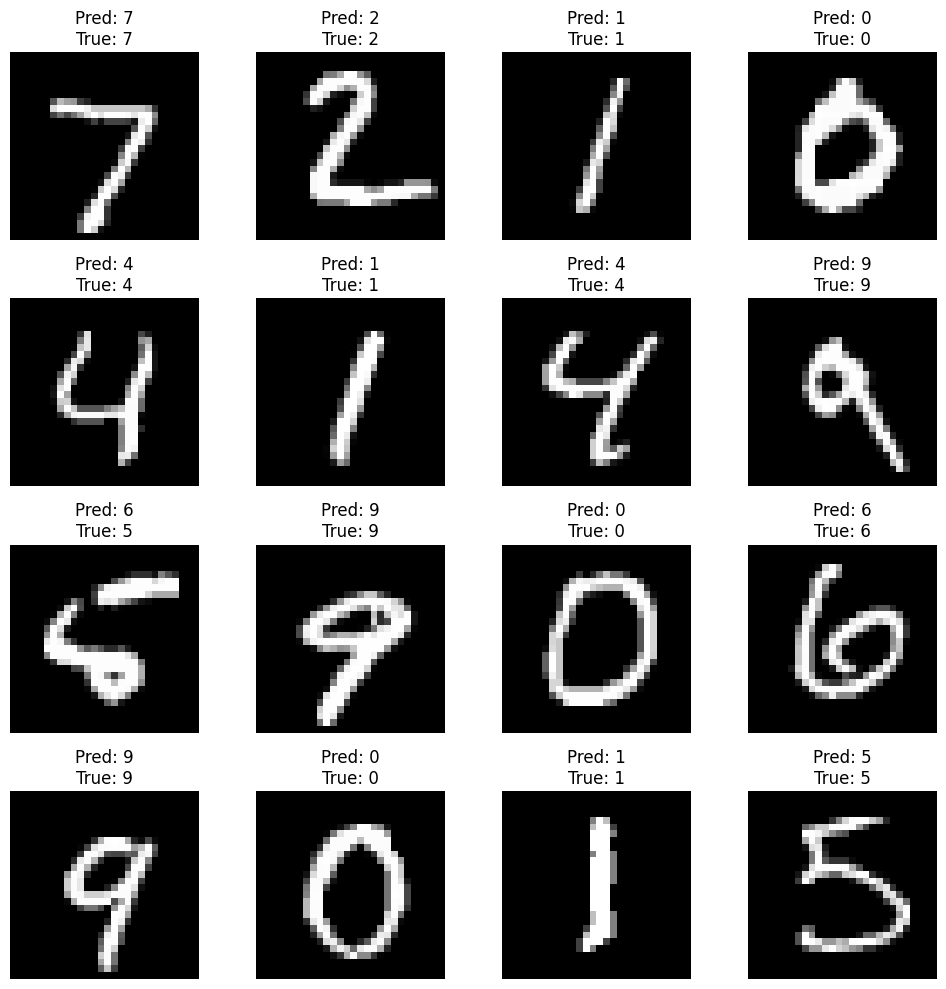

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert images to numpy arrays for visualization
images = images.numpy()

# Plot the images with their predicted and actual labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f'Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Adding Grad-CAM (Gradient-weighted Class Activation Mapping) is a great way to visualize which parts of an image the model is focusing on when making predictions. Grad-CAM highlights the regions of the image that were most influential in the model's decision.

To implement Grad-CAM in PyTorch, we need to:

Hook into the activations of the last convolutional layer.

Compute gradients of the target class with respect to those activations.

Combine the activations and gradients to produce the heatmap.

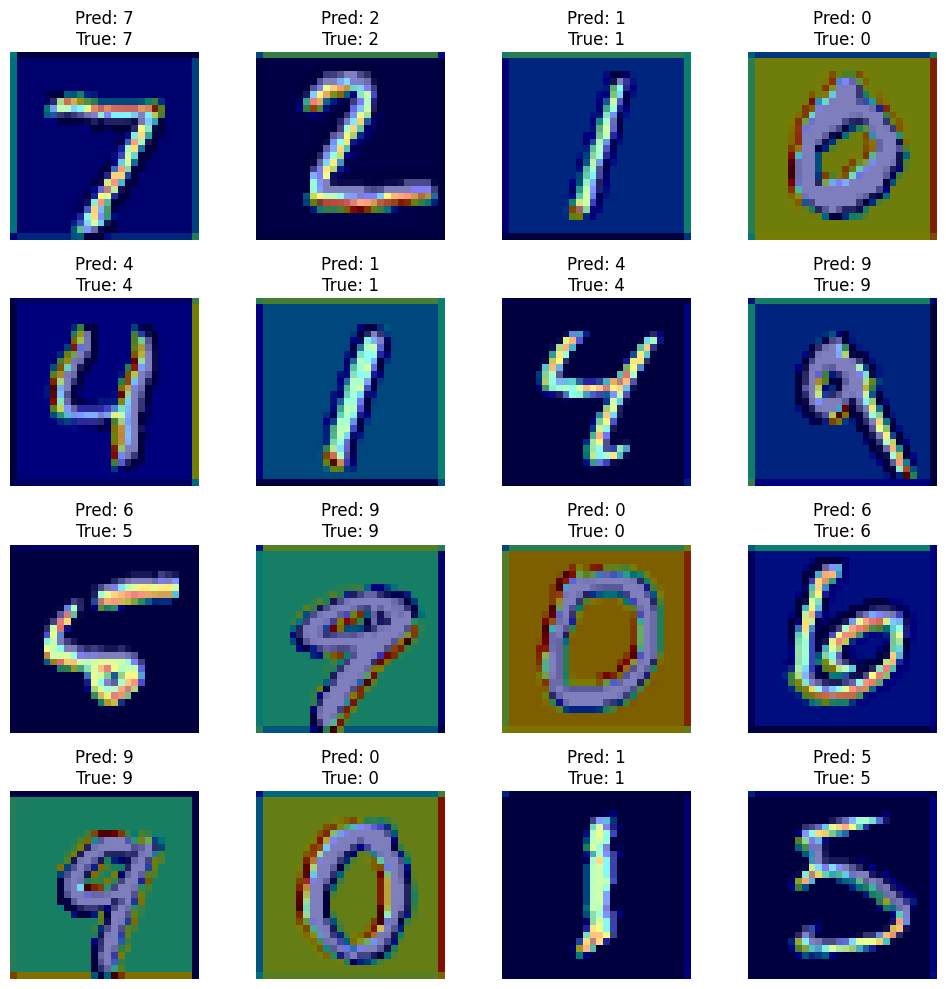

In [10]:
import torch.nn.functional as F

# Hook into the activations of the last convolutional layer
activations = None
def hook_fn(module, input, output):
    global activations
    activations = output

# Register the hook
model.conv1.register_forward_hook(hook_fn)

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Forward pass
images.requires_grad_()  # Enable gradient computation for the input images
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Backward pass to get gradients
model.zero_grad()
loss = F.cross_entropy(outputs, labels)
loss.backward(retain_graph=True)  # Retain the graph for Grad-CAM computation

# Grad-CAM computation
grads = torch.autograd.grad(loss, activations, retain_graph=True)[0]  # Retain graph here as well
pooled_grads = grads.mean(dim=(2, 3), keepdim=True)
heatmap = (activations * pooled_grads).sum(dim=1, keepdim=True)
heatmap = F.relu(heatmap)  # Apply ReLU to the heatmap
heatmap /= heatmap.max()  # Normalize the heatmap

# Convert heatmap to numpy for visualization
heatmap = heatmap.squeeze().detach().numpy()

# Plot the original image and heatmap
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(np.squeeze(images[idx].detach().numpy()), cmap='gray')
    ax.imshow(heatmap[idx], cmap='jet', alpha=0.5)  # Overlay heatmap
    ax.set_title(f'Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

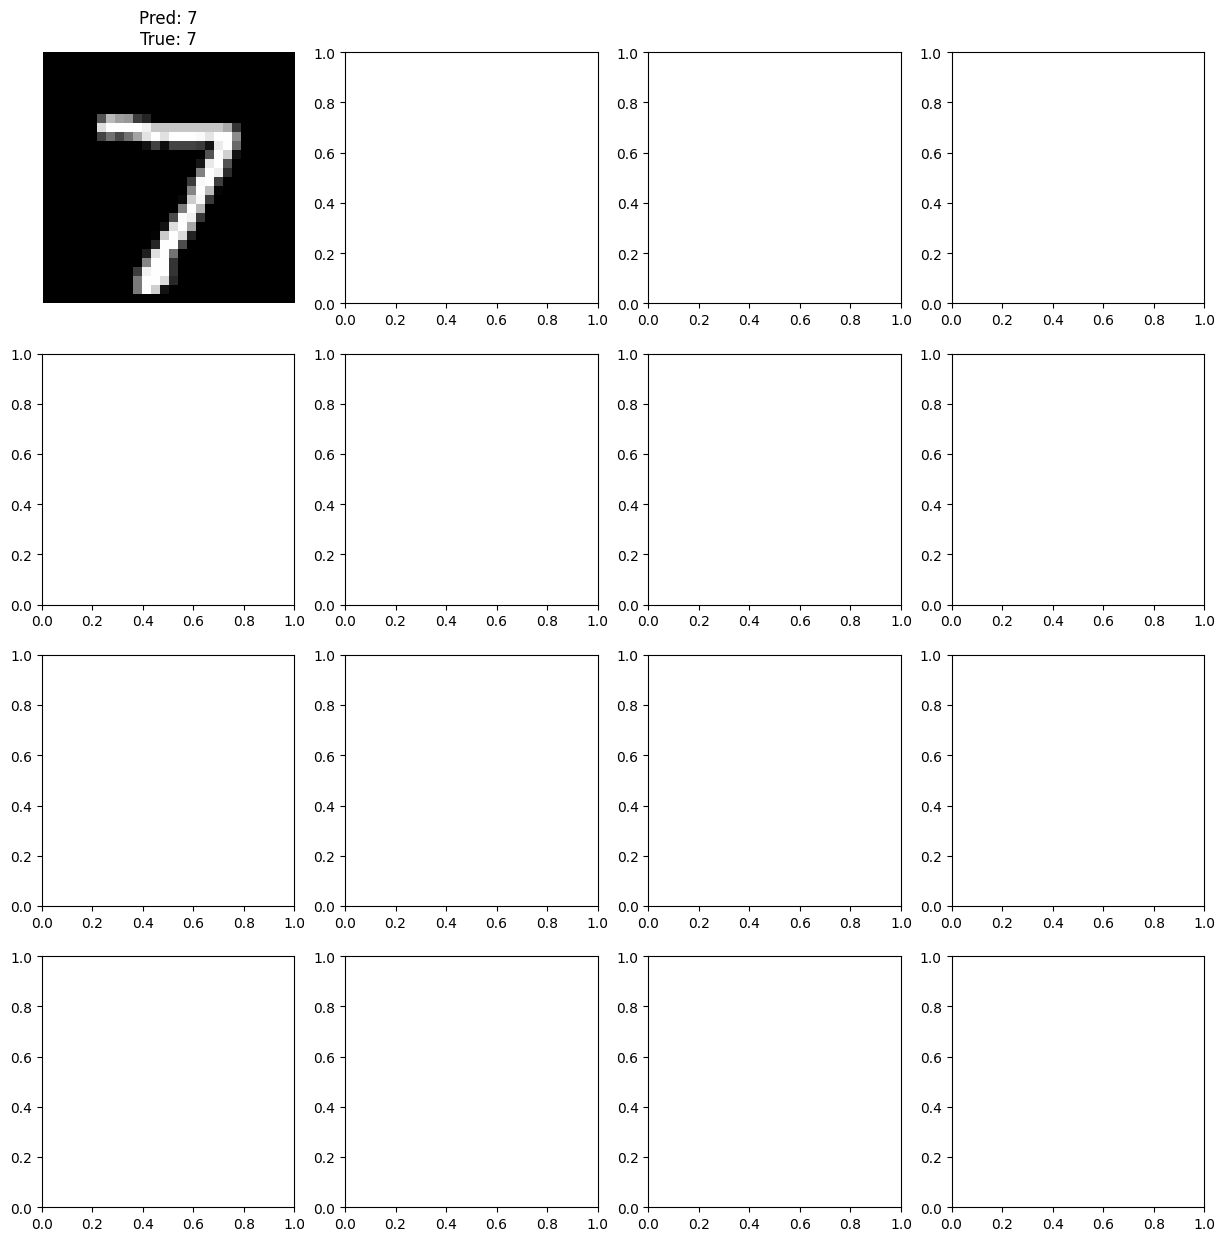

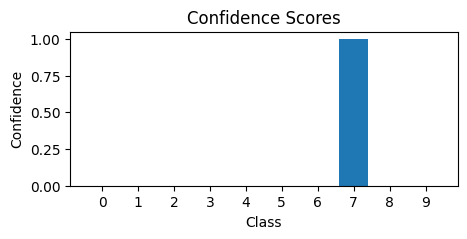

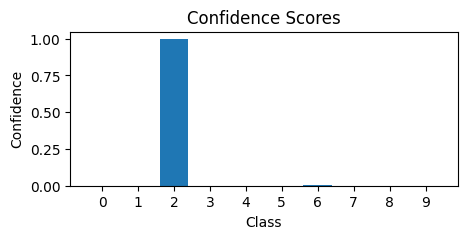

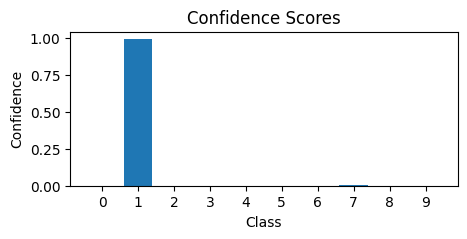

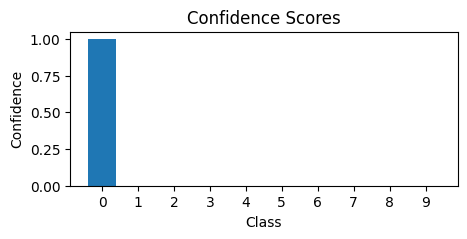

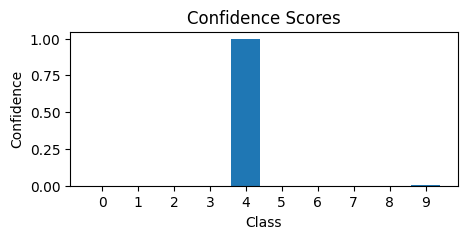

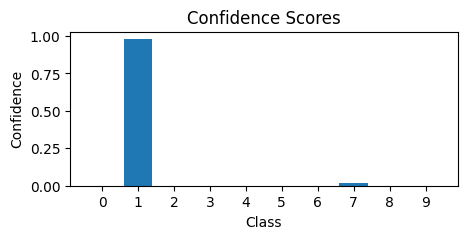

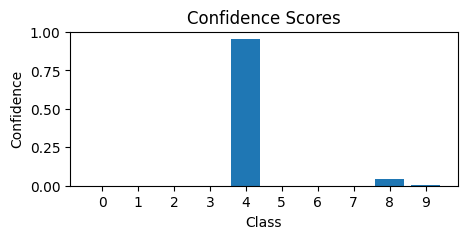

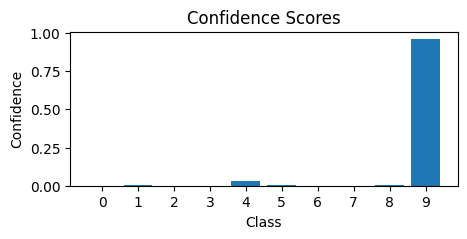

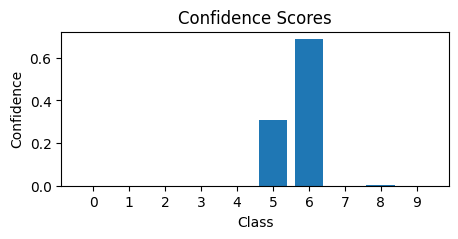

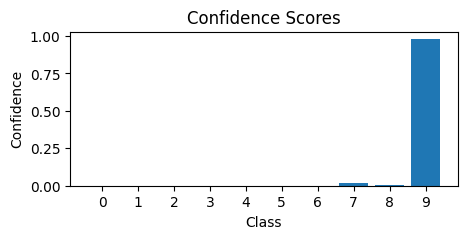

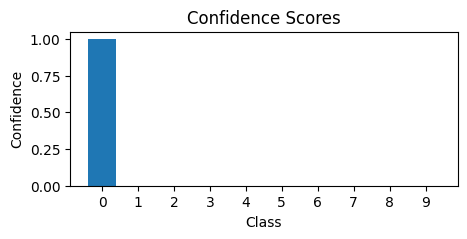

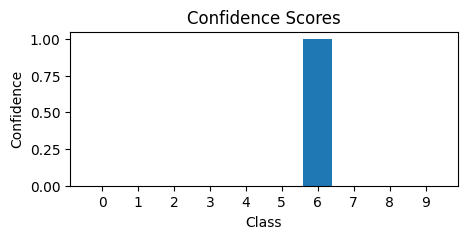

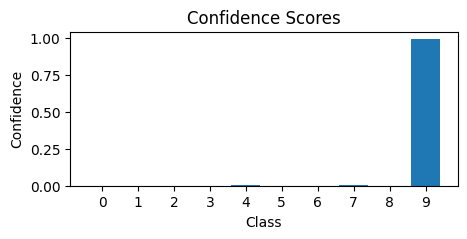

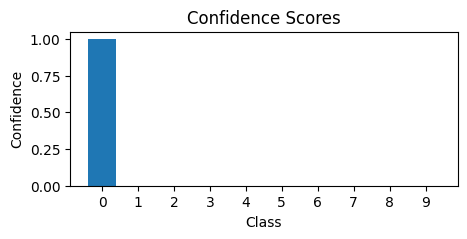

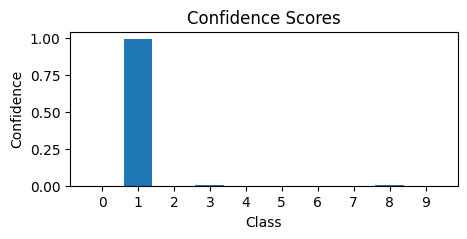

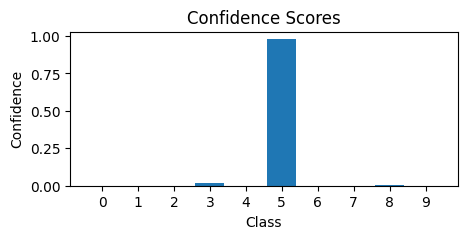

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
    _, predicted = torch.max(probabilities, 1)

# Convert images and probabilities to numpy arrays for visualization
images = images.numpy()
probabilities = probabilities.numpy()

# Plot the images with their predicted labels and confidence scores
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for idx, ax in enumerate(axes.ravel()):
    # Display the image
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f'Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}')
    ax.axis('off')

    # Display the confidence scores as a bar chart
    fig2, ax2 = plt.subplots(figsize=(5, 2))
    ax2.bar(range(10), probabilities[idx])
    ax2.set_xticks(range(10))
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Confidence')
    ax2.set_title('Confidence Scores')
    plt.show()